In [81]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.ensemble.forest import _generate_unsampled_indices
from sklearn.ensemble.forest import _generate_sample_indices

from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

from tqdm import tqdm

from joblib import Parallel, delayed

In [3]:
# Should use this class to generate CIFAR fig..
class LifelongForest:
    """
    Lifelong Forest class.
    """
    def __init__(self, acorn=None):
        """
        Two major things the Forest Class needs access to:
            1) the realized random forest model (self.models_ is a list of forests, 1 for each task)
            2) old data (to update posteriors when a new task is introduced)
        """
        self.models_ = []
        self.X_ = []
        self.y_ = []
        self.n_tasks = 0
        self.n_classes = None
        
        if acorn is not None:
            np.random.seed(acorn)
    
    def new_forest(self, X, y, n_estimators=200, max_samples=0.32,
                        bootstrap=True, max_depth=30, min_samples_leaf=1,
                        acorn=None):
        """
        Input
        X: an array-like object of features; X.shape == (n_samples, n_features)
        y: an array-like object of class labels; len(y) == n_samples
        n_estimators: int; number of trees to construct (default = 200)
        max_samples: float in (0, 1]: number of samples to consider when 
            constructing a new tree (default = 0.32)
        bootstrap: bool; If True then the samples are sampled with replacement
        max_depth: int; maximum depth of a tree
        min_samples_leaf: int; minimum number of samples in a leaf node
        
        Return
        model: a BaggingClassifier fit to X, y
        """
        
        if X.ndim == 1:
            raise ValueError('1d data will cause headaches down the road')
            
        if acorn is not None:
            np.random.seed(acorn)
            
        self.X_.append(X)
        self.y_.append(y)
            
        n = X.shape[0]
        K = len(np.unique(y))
        
        if self.n_classes is None:
            self.n_classes = K
        
        max_features = int(np.ceil(np.sqrt(X.shape[1])))

        model=BaggingClassifier(DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf,
                                                         max_features = max_features),
                                  n_estimators=n_estimators,
                                  max_samples=max_samples,
                                  bootstrap=bootstrap)

        model.fit(X, y)
        self.models_.append(model)
        self.n_tasks += 1
        self.n_classes = len(np.unique(y))
        
        return model
    
    
    def _get_leaves(self, estimator):
        """
        Internal function to get leaf node ids of estimator.
        
        Input
        estimator: a fit DecisionTreeClassifier
        
        Return
        leaf_ids: numpy array; an array of leaf node ids
        
        Usage
        _estimate_posteriors(..)
        """
        
        # adapted from https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html
        n_nodes = estimator.tree_.node_count
        children_left = estimator.tree_.children_left
        children_right = estimator.tree_.children_right
        feature = estimator.tree_.feature
        threshold = estimator.tree_.threshold

        leaf_ids = []
        stack = [(0, -1)] 
        while len(stack) > 0:
            node_id, parent_depth = stack.pop()

            # If we have a test node
            if (children_left[node_id] != children_right[node_id]):
                stack.append((children_left[node_id], parent_depth + 1))
                stack.append((children_right[node_id], parent_depth + 1))
            else:
                leaf_ids.append(node_id)

        return np.array(leaf_ids)
    
    
    def _finite_sample_correction(self, class_probs, row_sums):
        """
        An internal function for finite sample correction of posterior estimation.
        
        Input
        class_probs: numpy array; array of posteriors to correct
        row_sums: numpy array; array of partition counts
        
        Output
        class_probs: numpy array; finite sample corrected posteriors
        
        Usage
        _estimate_posteriors(..)
        
        """
    
        where_0 = np.argwhere(class_probs == 0)
        for elem in where_0:
            class_probs[elem[0], elem[1]] = 1 / (2 * row_sums[elem[0], None])
        where_1 = np.argwhere(class_probs == 1)
        for elem in where_1:
            class_probs[elem[0], elem[1]] = 1 - 1 / (2 * row_sums[elem[0], None])
    
        return class_probs
    
    
    def _estimate_posteriors(self, test, representation=0, decider=0, subsample=1, acorn=None):
        """
        An internal function to estimate the posteriors.
        
        Input
        task_number: int; indicates which model in self.model_ to use
        test: array-like; test observation
        in_task: bool; True if test is an in-task observation(s)
        subsample: float in (0, 1]; proportion of out-of-task samples to use to
            estimate posteriors
            
        Return
        probs: numpy array; probs[i, k] is the probability of observation i
            being class k
            
        Usage
        predict(..)
        """
        
        if acorn is not None:
            acorn = np.random.seed(acorn)
            
        if representation==decider:
            in_task=True
        else:
            in_task=False
            
        train = self.X_[decider]
        y = self.y_[decider]
            
        model = self.models_[representation]

        n, d = train.shape
        
        if test.ndim > 1:
            m, d_ = test.shape
        else:
            m = len(test)
            d_ = 1
        
        size = len(np.unique(y))
        class_counts = np.zeros((m, size))
        for tree in model:
            # get out of bag indicies
            if in_task:
                prob_indices = _generate_unsampled_indices(tree.random_state, n)
                # in_bag_idx = _generate_sample_indices(tree.random_state, n) # this is not behaving as i expected
            else:
                prob_indices = np.random.choice(range(n), size=int(subsample*n), replace=False)

            leaf_nodes = self._get_leaves(tree)
            unique_leaf_nodes = np.unique(leaf_nodes)

            # get all node counts
            node_counts = tree.tree_.n_node_samples
            # get probs for eval samples
            posterior_class_counts = np.zeros((len(unique_leaf_nodes), size))

            for prob_index in prob_indices:
                temp_node = tree.apply(train[prob_index].reshape(1, -1)).item()
                posterior_class_counts[np.where(unique_leaf_nodes == temp_node)[0][0], y[prob_index]] += 1

            # total number of points in a node
            row_sums = posterior_class_counts.sum(axis=1)

            # no divide by zero
            row_sums[row_sums == 0] = 1

            # posteriors
            class_probs = (posterior_class_counts / row_sums[:, None])
            # posteriors with finite sampling correction

            class_probs = self._finite_sample_correction(class_probs, row_sums)

            # posteriors as a list
            class_probs.tolist()

            partition_counts = np.asarray([node_counts[np.where(unique_leaf_nodes == x)[0][0]] for x in tree.apply(test)])
            # get probability for out of bag samples
            eval_class_probs = [class_probs[np.where(unique_leaf_nodes == x)[0][0]] for x in tree.apply(test)]
            eval_class_probs = np.array(eval_class_probs)
            # find total elements for out of bag samples
            elems = np.multiply(eval_class_probs, partition_counts[:, np.newaxis])
            # store counts for each x (repeat fhis for each tree)
            class_counts += elems
        # calculate p(y|X = x) for all x's
        probs = class_counts / class_counts.sum(axis=1, keepdims=True)

        return probs


    def predict(self, test, representation=0, decider='all', subsample=1, acorn=None):
        """
        Predicts the class labels for each sample in test.
        
        Input
        test: array-like; either a 1d array of length n_features
            or a 2d array of shape (m, n_features) 
        task_number: int; task number 
        """
        
        size=len(np.unique(self.y_[decider]))
        sum_posteriors = np.zeros((test.shape[0], size))
        
        if representation is 'all':
            for i in range(self.n_tasks):
                sum_posteriors += self._estimate_posteriors(test,
                                                            i,
                                                            decider,
                                                            subsample,
                                                            acorn)
            
        else:
            sum_posteriors += self._estimate_posteriors(test,
                                                        representation,
                                                        decider,
                                                        subsample,
                                                        acorn)
                
        return np.argmax(sum_posteriors, axis=1)

In [6]:
def generate_2d_rotation(theta=0, acorn=None):
    if acorn is not None:
        np.random.seed(acorn)
    
    R = np.array([
        [np.cos(theta), np.sin(theta)],
        [-np.sin(theta), np.cos(theta)]
    ])
    
    return R

def generate_gaussian_parity(n, mean=np.array([-1, -1]), cov_scale=1, angle_params=None, k=1, acorn=None):
    if acorn is not None:
        np.random.seed(acorn)
        
    d = len(mean)
    
    if mean[0] == -1 and mean[1] == -1:
        mean = mean + 1 / 2**k
    
    mnt = np.random.multinomial(n, 1/(4**k) * np.ones(4**k))
    cumsum = np.cumsum(mnt)
    cumsum = np.concatenate(([0], cumsum))
    
    Y = np.zeros(n)
    X = np.zeros((n, d))
    
    for i in range(2**k):
        for j in range(2**k):
            temp = np.random.multivariate_normal(mean, cov_scale * np.eye(d), 
                                                 size=mnt[i*(2**k) + j])
            temp[:, 0] += i*(1/2**(k-1))
            temp[:, 1] += j*(1/2**(k-1))
            
            X[cumsum[i*(2**k) + j]:cumsum[i*(2**k) + j + 1]] = temp
            
            if i % 2 == j % 2:
                Y[cumsum[i*(2**k) + j]:cumsum[i*(2**k) + j + 1]] = 0
            else:
                Y[cumsum[i*(2**k) + j]:cumsum[i*(2**k) + j + 1]] = 1
                
    if d == 2:
        if angle_params is None:
            angle_params = np.random.uniform(0, 2*np.pi)
            
        R = generate_2d_rotation(angle_params)
        X = X @ R
        
    else:
        raise ValueError('d=%i not implemented!'%(d))
       
    return X, Y.astype(int)

def get_colors(colors, inds):
    c = [colors[i] for i in inds]
    return c

def deg_to_rad(deg):
    return deg * np.pi / 180

In [110]:
def rxor_suite_experiment(n_training_sets, ns, fracs, func, m=300, acorn=None):
    if acorn is not None:
        np.random.seed(acorn)
    
    n_tasks = len(fracs)
    
    assert n_tasks == len(ns)
    
    errors = [np.zeros(n_tasks-i) for i in range(n_tasks)]
    STL_errors = np.zeros(n_tasks)

    ratios = [np.zeros(n_tasks-i) for i in range(n_tasks)]
    
    for i in range(n_tasks):
        risks = np.zeros((i+1,n_training_sets)) 
        STL_risks = np.zeros(n_training_sets) 
        for s in range(n_training_sets):
            L2F = LifelongForest()
            for j, f in enumerate(fracs[:i+1]):
                temp_X, temp_y = func(ns[j], angle_params=f, cov_scale=0.1)
                L2F.new_forest(temp_X, temp_y, n_estimators=int(np.sqrt(ns[j])))

            for j, f in enumerate(fracs[:i+1]):
                test_X, test_y = func(m, angle_params=f, cov_scale=0.1)

                risks[j,s] = 1 - np.sum(L2F.predict(test_X, representation='all', decider=j) == test_y)/m
            STL_risks[s] = 1 - np.sum(L2F.predict(test_X, representation=i, decider=i) == test_y)/m

        STL_errors[i] = np.mean(STL_risks)

        average_risks = np.mean(risks, axis=1)
        for j in range(i+1):
            errors[j][i-j] = average_risks[j]

    for i in range(n_tasks):
        ratios[i][:] = STL_errors[i] / errors[i]
        
    return ratios

In [111]:
np.random.seed(1)

fracs = np.pi / 4 - np.array([deg_to_rad(2*i) for i in range(9)])
fracs = fracs[::-1]
fracs = np.concatenate(([0], fracs))

n_mc=40 # n monte carlo iterations
n_training_sets=50
m=500 # amount of data from each task to estimate the risk


n_tasks = len(fracs)
ns = n_tasks * [100]

n1s = np.array([50, 100, 200, 500, 1000])

In [113]:
ratios = [[np.zeros((n_tasks-i, n_mc)) for i in range(n_tasks)] for j in n1s]

for k, n1 in enumerate(tqdm(n1s)): 
    ns[0] = n1
    
    condensed_func = lambda x : rxor_suite_experiment(x, ns, fracs, generate_gaussian_parity)
    
    temp_ratios = np.array(Parallel(n_jobs=-2)(delayed(condensed_func)(int(x)) for x in 30*np.ones(10)))
    
    for i in range(n_tasks):
        ratios[k][i] = np.array([temp_ratios[_][i] for _ in range(10)])































  0%|          | 0/5 [00:00<?, ?it/s]

[50, 100, 100, 100, 100, 100, 100, 100, 100, 100]


KeyboardInterrupt: 

In [92]:
temp_ratios

[[array([1.        , 0.88495575, 0.92592593]),
  array([1.19327731, 1.36538462]),
  array([1.5483871])],
 [array([1.        , 0.77586207, 0.80357143]),
  array([1.22222222, 1.18705036]),
  array([1.4469697])]]

In [ ]:
import seaborn as sns
sns.set()

mean_ratios = [[np.mean(ratios[k][i],axis=0) for i in range(3)] for k in range(len(n1s))]
std_ratios = [[np.std(ratios[k][i],ddof=1,axis=0) for i in range(3)] for k in range(len(n1s))]

0 0
1 0
0 1
1 1
0 2
1 2
0 3
1 3
0 4
1 4


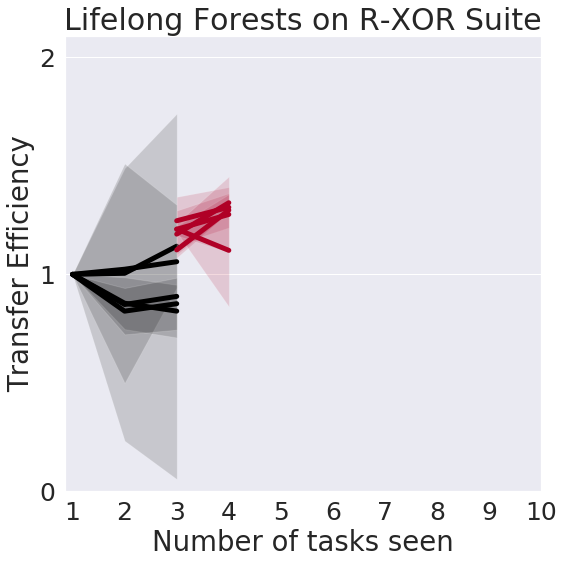

In [73]:
# mean_opt_ratios = [np.mean(optimal_ratios[i],axis=0) for i in range(n_tasks)]

fig, ax = plt.subplots(1,1, figsize=(8,8))
c = sns.color_palette('YlOrRd', n_colors=9)
c = np.concatenate((c, [(0,0,0)]))

for k in range(len(n1s)):
    for i in range(3 - 1):
        print(i, k)
        ns = np.arange(i + 1, n_tasks + 1)
        ax.plot(ns[i:3],np.array(mean_ratios[k][i]), label = 'task %i'%(i+1), c=c[-i-1], linewidth=5, zorder=i+1)
    #     ax.plot(ns, mean_ratios[i])

        ax.fill_between(ns[i:3], 
            mean_ratios[k][i] + 1.96*std_ratios[k][i]/np.sqrt(n_mc), 
            mean_ratios[k][i] - 1.96*std_ratios[k][i]/np.sqrt(n_mc), 
            where=mean_ratios[k][i] + 1.96*std_ratios[k][i]/np.sqrt(n_mc) >= mean_ratios[k][i] - 1.96*std_ratios[k][i]/np.sqrt(n_mc), 
            facecolor=c[-i-1], 
            alpha=0.15,
            interpolate=True, zorder=i+1)
    
    
# ax.scatter(n_tasks, mean_ratios[-1], c = c[0], label='task %i'%(n_tasks), s = 20,zorder=11)
# ax.errorbar(10, mean_ratios[-1], yerr=1.96*std_ratios[-1]/np.sqrt(n_mc), c=c[0], zorder=11)

    
ax.set_title('Lifelong Forests on R-XOR Suite', fontsize=30)
ax.set_xlabel('Number of tasks seen', fontsize=27.5)
ax.set_ylabel('Transfer Efficiency', fontsize=27.5)
ax.set_ylim(0, 2.1)
ax.set_xticks(np.arange(1,n_tasks+1))
ax.set_yticks([0, 1, 2])
ax.tick_params(labelsize=25)
ax.grid(axis='x')
plt.tight_layout()
# plt.savefig('rxors_suite_combined.png', dpi=500)

In [64]:
mean_ratios[0][0]

array([1.16983155, 0.66984984])

In [15]:
errors = [[np.zeros((n_tasks-i, n_mc)) for i in range(n_tasks)] for j in n1s]
STL_errors = np.zeros((len(n1s), n_tasks, n_mc))

ratios = [[np.zeros((n_tasks-i, n_mc)) for i in range(n_tasks)] for j in n1s]

d=2

for k, n1 in enumerate(tqdm(n1s)): 
    ns[0] = n1
    
    # can trivially parallelize below
    for _ in tqdm(range(n_mc)):
        for i in range(n_tasks):
            risks = np.zeros((i+1,n_training_sets)) 
            STL_risks = np.zeros(n_training_sets) 
            for s in range(n_training_sets):
                L2F = LifelongForest()
                for j, f in enumerate(fracs[:i+1]):
                    temp_X, temp_y = generate_gaussian_parity(ns[j], cov_scale=0.1, angle_params=f, k=1)
                    L2F.new_forest(temp_X, temp_y, n_estimators=int(np.sqrt(ns[j])))

                for j, f in enumerate(fracs[:i+1]):
                    test_X, test_y = generate_gaussian_parity(m, cov_scale=0.1, angle_params=f, k=1)

                    risks[j,s] = 1 - np.sum(L2F.predict(test_X, representation='all', decider=j) == test_y)/m
                STL_risks[s] = 1 - np.sum(L2F.predict(test_X, representation=i, decider=i) == test_y)/m

            STL_errors[k, i, _] = np.mean(STL_risks)

            average_risks = np.mean(risks, axis=1)
            for j in range(i+1):
                errors[k][j][i-j, _] = average_risks[j]

        for i in range(n_tasks):
            ratios[k][i][:, _] = STL_errors[k, i, _] / errors[k][i][:, _]